In [1]:
import finterstellar as fs
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
symbol = 'MSFT'
df_msft = fs.get_price(symbol, start_date="2023-01-01", end_date="2024-12-27")
fs.draw_chart(df_msft, right=symbol)

## MACD 전략

In [ ]:
fs.macd(df_msft)

In [ ]:
fs.draw_chart(df=df_msft, right = ['macd','macd_signal', 'macd_oscillator'])

In [ ]:
fs.indicator_to_signal(df_msft, factor='macd_oscillator', buy=0, sell=0)

In [ ]:
df_msft

In [ ]:
fs.position(df_msft)
df_msft

In [ ]:
fs.draw_chart(df_msft, left='macd_oscillator',right='position_chart')

In [ ]:
fs.evaluate(df_msft, cost=0.001)

In [ ]:
fs.performance(df_msft, rf_rate=0.01)

In [ ]:
fs.draw_trade_results(df_msft)

## RSI 전략

In [ ]:
symbol = 'VZ'
df_vz = fs.get_price(symbol, start_date="2024-12-01", end_date="2024-12-31")
fs.draw_chart(df_vz, right=symbol)

In [ ]:
fs.rsi(df_vz, w=14)
df_vz

In [ ]:
fs.draw_chart(df_vz, left='rsi', right=symbol)

In [ ]:
fs.indicator_to_signal(df_vz, factor='rsi', buy=30, sell=70)
fs.position(df_vz)
df_vz

In [ ]:
fs.evaluate(df_vz, cost=0.001)

In [ ]:
fs.performance(df_vz, rf_rate=0.01)

In [ ]:
fs.draw_trade_results(df_vz)

In [ ]:
fs.indicator_to_signal(df_vz, factor='rsi', buy=70, sell=50)
fs.position(df_vz)
df_vz

In [ ]:
fs.evaluate(df_vz, cost=0.001)
fs.performance(df_vz, rf_rate=0.01)

In [ ]:
fs.draw_trade_results(df_vz)

## Bollinger Band 전략

In [ ]:
symb_tsm = 'TSM'

df_tsm = fs.get_price(symb_tsm, start_date = '2020-01-01', end_date='2020-12-31')
fs.draw_chart(df_tsm, right=symb_tsm)

In [ ]:
fs.bollinger(df_tsm, w=20, k=2)
df_tsm.tail()

In [ ]:
fs.draw_band_chart(df_tsm)

In [ ]:
fs.band_to_signal(df_tsm, buy='A', sell='B')

In [ ]:
fs.position(df_tsm)
df_tsm.tail(10)

In [ ]:
df_tmp = df_tsm.copy()
df_tmp

In [ ]:
df_tmp['signal_price']=np.nan
df_tmp['signal_price'].mask(df_tmp['position']=='zl', df_tmp.iloc[:,0], inplace=True)
df_tmp['signal_price'].mask(df_tmp['position']=='lz', df_tmp.iloc[:,0], inplace=True)
df_tmp[df_tmp['signal_price']>0]

In [ ]:
record_tmp = df_tmp[['position','signal_price']].dropna()
record_tmp['rtn'] = 1
record_tmp['rtn'].mask(record_tmp['position'] == 'lz', record_tmp['signal_price'] * (1-.001)/record_tmp['signal_price'].shift(1), inplace=True)
record_tmp

In [ ]:
record_tmp['acc_rtn'] = record_tmp['rtn'].cumprod()
record_tmp

In [ ]:
df_tmp['signal_price'].mask(df_tmp['position']=='ll', df_tmp.iloc[:,0], inplace=True)
df_tmp

In [ ]:
df_tmp['rtn'] = record_tmp['rtn']
df_tmp.tail(20)

In [ ]:
df_tmp['rtn'].fillna(1, inplace=True)
df_tmp.tail(20)

In [ ]:
df_tmp['daily_rtn'] = 1
df_tmp['daily_rtn'].mask(df_tmp['position'] == 'll', df_tmp['signal_price'] / df_tmp['signal_price'].shift(1), inplace=True)
df_tmp.tail(30)

In [ ]:
df_tmp['daily_rtn'].mask(df_tmp['position'] == 'lz', (df_tmp['signal_price']*(1-0.001)) / df_tmp['signal_price'].shift(1), inplace=True)
df_tmp.head(30)

In [ ]:
df_tmp.info()

In [ ]:
df_tmp['daily_rtn'].fillna(1, inplace=True)
df_tmp[df_tmp['position']=='ll']

In [ ]:
df_tmp['acc_rtn'] = df_tmp['daily_rtn'].cumprod()
df_tmp

In [ ]:
df_tmp['acc_rtn_dp'] = ((df_tmp['acc_rtn']-1)*100).round(2)
df_tmp

In [ ]:
df_tmp['acc_rtn'].cummax()

In [ ]:
df_tmp['mdd'] = (df_tmp['acc_rtn']/df_tmp['acc_rtn'].cummax()).round(4)
df_tmp

In [ ]:
df_tmp['bm_mdd'] = (df_tmp.iloc[:,0] / df_tmp.iloc[:,0].cummax()).round(4)
df_tmp.tail(20)

In [ ]:
df_tmp.drop(columns='signal_price', inplace=True)
df_tmp

In [ ]:
fs.evaluate(df_tsm, cost=.001)
df_tsm.tail(20)

In [ ]:
def __get_period(df):
    df.dropna(inplace=True)
    end_date = df.index[-1]
    start_date = df.index[0]
    days_between = (end_date - start_date).days
    return abs(days_between)


def __annualize(rate, period):
    if period < 360:
        rate = ((rate-1) / period * 365) + 1
    elif period > 365:
        rate = rate ** (365 / period)
    else:
        rate = rate
    return round(rate, 4)


def __get_sharpe_ratio(df, rf_rate):
    '''
    Calculate sharpe ratio
    :param df:
    :param rf_rate:
    :return: Sharpe ratio
    '''
    period = __get_period(df)
    rf_rate_daily = rf_rate / 365 + 1
    df['exs_rtn_daily'] = df['daily_rtn'] - rf_rate_daily
    exs_rtn_annual = (__annualize(df['acc_rtn'][-1], period) - 1) - rf_rate
    exs_rtn_vol_annual = df['exs_rtn_daily'].std() * np.sqrt(365)
    sharpe_ratio = exs_rtn_annual / exs_rtn_vol_annual if exs_rtn_vol_annual>0 else 0
    return round(sharpe_ratio, 4)

In [ ]:
rst = {}
rst['no_trades'] = (df_tmp['position']=='zl').sum()
rst['no_win'] = (df_tmp['rtn']>1).sum()
rst['acc_rtn'] = df_tmp['acc_rtn'][-1].round(4)
rst['hit_ratio'] = round((df_tmp['rtn']>1).sum() / rst['no_trades'], 4) if rst['no_trades']>0 else 0
rst['avg_rtn'] = round(df_tmp[df_tmp['rtn']!=1]['rtn'].mean(), 4)
rst['period'] = __get_period(df_tmp)
rst['annual_rtn'] = __annualize(rst['acc_rtn'], rst['period'])
rst['bm_rtn'] = round(df_tmp.iloc[-1,0]/df_tmp.iloc[0,0], 4)
rst['sharpe_ratio'] = __get_sharpe_ratio(df_tmp, 0.01)
rst['mdd'] = df_tmp['mdd'].min()
rst['bm_mdd'] = df_tmp['bm_mdd'].min()

rst

In [ ]:
rst_tsm = {}
rst_tsm['no_trades'] = (df_tsm['position']=='zl').sum()
rst_tsm['no_win'] = (df_tsm['rtn']>1).sum()
rst_tsm['acc_rtn'] = df_tsm['acc_rtn'][-1].round(4)
rst_tsm['hit_ratio'] = round((df_tsm['rtn']>1).sum() / rst_tsm['no_trades'], 4) if rst_tsm['no_trades']>0 else 0
rst_tsm['avg_rtn'] = round(df_tsm[df_tsm['rtn']!=1]['rtn'].mean(), 4)
rst_tsm['period'] = __get_period(df_tsm)
rst_tsm['annual_rtn'] = __annualize(rst_tsm['acc_rtn'], rst_tsm['period'])
rst_tsm['bm_rtn'] = round(df_tsm.iloc[-1,0]/df_tsm.iloc[0,0], 4)
rst_tsm['sharpe_ratio'] = __get_sharpe_ratio(df_tsm, 0.01)
rst_tsm['mdd'] = df_tsm['mdd'].min()
rst_tsm['bm_mdd'] = df_tsm['bm_mdd'].min()

rst_tsm

In [ ]:
df_tsm.shape

In [ ]:
df_tmp.shape

In [ ]:
fs.performance(df_tsm, rf_rate=0.01)
fs.draw_trade_results(df_tsm)

In [ ]:
fs.band_to_signal(df_tsm, buy='D', sell='B')
fs.position(df_tsm)
fs.evaluate(df_tsm, cost=0.001)
fs.performance(df_tsm, rf_rate=0.01)
fs.draw_trade_results(df_tsm)

In [ ]:
df_tsm_com = fs.get_price(symb_tsm, start_date='2020-01-01', end_date='2020-12-31')
df_tsm_com = fs.bollinger(df_tsm_com, w=20,k=1)
df_tsm_com

In [ ]:
df_tsm_com['s1'] = fs.band_to_signal(df_tsm_com, buy='A', sell='B')
df_tsm_com['s2'] = fs.band_to_signal(df_tsm_com, buy='D', sell='B')
df_tsm_com

In [ ]:
fs.combine_signal_or(df_tsm_com, 's1', 's2')

In [ ]:
fs.position(df_tsm_com)
fs.evaluate(df_tsm_com, cost=0.001)
fs.performance(df_tsm_com, rf_rate=0.01)
fs.draw_trade_results(df_tsm_com)

## Stochastic 전략

In [15]:
sym_sto = 'ISRG'

df_sto = fs.get_ohlc(sym_sto, start_date = '2024-01-01', end_date='2025-01-31' )
df_sto.tail()

,Open,High,Low,Close,Volume,Adj Close
2025-01-27,574.68,579.34,563.35,573.48,2441600,573.48
2025-01-28,566.60,584.48,563.85,574.14,2332100,574.14
2025-01-29,571.11,578.41,569.49,572.71,1597900,572.71
2025-01-30,581.24,584.42,577.35,580.18,1986700,580.18
2025-01-31,576.74,586.89,570.86,571.88,1826100,571.88


In [16]:
fs.stochastic(df_sto, sym_sto)

,ISRG,slow_k,slow_d
2024-01-02,330.98,NaN,NaN
2024-01-03,322.13,NaN,NaN
2024-01-04,323.27,NaN,NaN
2024-01-05,322.50,NaN,NaN
2024-01-08,328.86,NaN,NaN
...,...,...,...
2025-01-27,573.48,69.15,82.80
2025-01-28,574.14,55.45,69.59
2025-01-29,572.71,50.37,58.32
2025-01-30,580.18,52.98,52.93


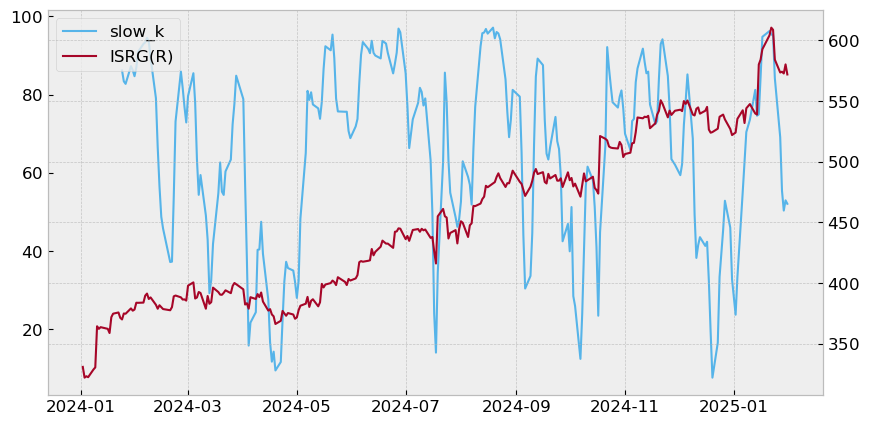

In [17]:
fs.draw_chart(df_sto, left='slow_k', right=sym_sto)

In [18]:
fs.indicator_to_signal(df_sto, factor='slow_k',buy=20, sell=80)

2024-01-02    zero
2024-01-03    zero
2024-01-04    zero
2024-01-05    zero
2024-01-08    zero
              ... 
2025-01-27    zero
2025-01-28    zero
2025-01-29    zero
2025-01-30    zero
2025-01-31    zero
Name: trade, Length: 272, dtype: object

CAGR: 25.91%
Accumulated return: 26.39%
Average return: 6.08%
Benchmark return : 52.60%
Number of trades: 4
Number of win: 4
Hit ratio: 100.00%
Investment period: 1.0yrs
Sharpe ratio: 1.28
MDD: -6.61%
Benchmark MDD: -8.55%


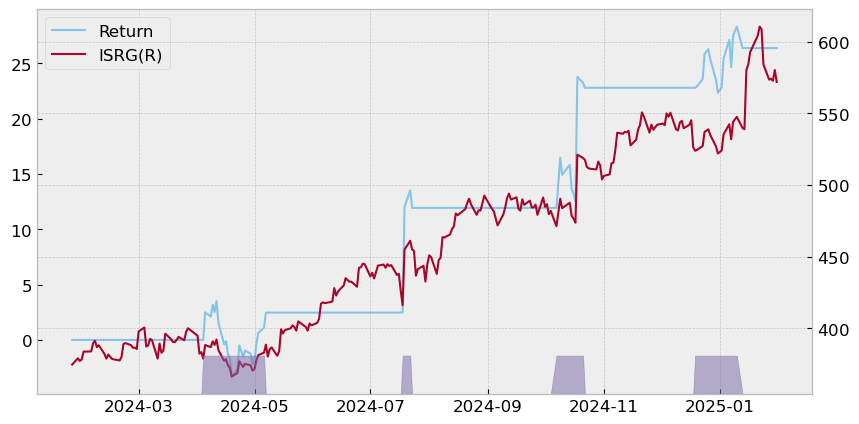

In [19]:
fs.position(df_sto)
fs.evaluate(df_sto, cost=0.001)
fs.performance(df_sto, rf_rate=0.01)
fs.draw_trade_results(df_sto)

In [20]:
df_sto2 = fs.get_ohlc(sym_sto, start_date = '2024-01-01', end_date='2025-01-31' )
fs.stochastic(df_sto2, sym_sto)
df_sto2.tail()

,ISRG,slow_k,slow_d
2025-01-27,573.48,69.15,82.80
2025-01-28,574.14,55.45,69.59
2025-01-29,572.71,50.37,58.32
2025-01-30,580.18,52.98,52.93
2025-01-31,571.88,52.10,51.82


In [21]:
df_sto2['indicator'] = df_sto2['slow_k'] - df_sto2['slow_d']
df_sto2.tail()

,ISRG,slow_k,slow_d,indicator
2025-01-27,573.48,69.15,82.80,-13.65
2025-01-28,574.14,55.45,69.59,-14.14
2025-01-29,572.71,50.37,58.32,-7.95
2025-01-30,580.18,52.98,52.93,0.05
2025-01-31,571.88,52.10,51.82,0.28


CAGR: -11.29%
Accumulated return: -11.46%
Average return: -0.27%
Benchmark return : 52.60%
Number of trades: 38
Number of win: 13
Hit ratio: 34.21%
Investment period: 1.0yrs
Sharpe ratio: -0.75
MDD: -17.94%
Benchmark MDD: -8.55%


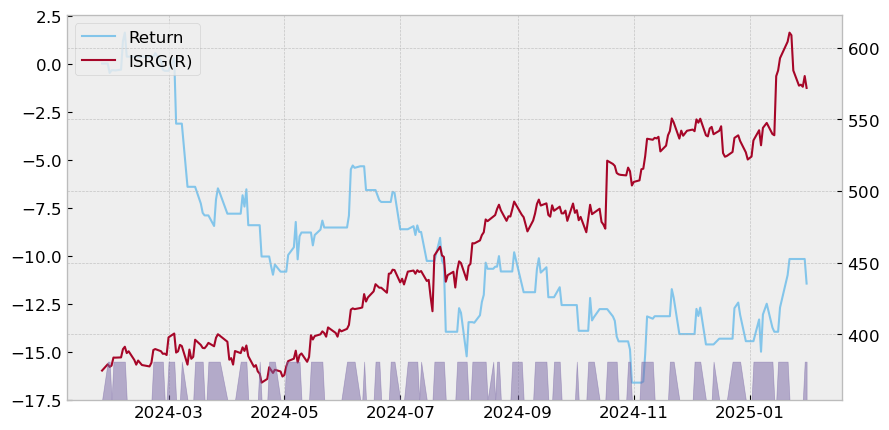

In [22]:
fs.indicator_to_signal(df_sto2, factor='indicator',buy=0, sell=0)
fs.position(df_sto2)
fs.evaluate(df_sto2, cost=0.001)
fs.performance(df_sto2, rf_rate=0.01)
fs.draw_trade_results(df_sto2)